## Importiere `pandas`, `matplotlib`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *
from matplotlib.patches import Patch

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [2]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [3]:
env = 'final'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

In [4]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [5]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [6]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Ändere die Spalte `ressort` zu einem Anfangsgroßbuchstaben

In [7]:
df.ressort = df.ressort.str.title()

#### Füge ein neues Feature hinzu: Themengebiet

In [8]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topics[topic]['name']

#### Fülle alle NaN Werte aus `rankings` mit einem leeren Array

In [9]:
df['rankings'] = df['rankings'].fillna("[]")

#### Füge ein neues Feature hinzu: Ranking besser als 5. Platz

In [10]:
def high_ranking(x):
    if (type(x) == list):
        return any(ranking['score'] <= 5 for ranking in x)
    return False

df['high_ranking'] = df['rankings'].apply(high_ranking)

#### Filter die Artikel nach: Hohes Ranking vorhanden

In [11]:
df = df.loc[df.high_ranking]

#### Gruppiere die Artikel nach: Themengebiet

In [12]:
df_ressort = df.groupby(["ressort"]).size().reset_index(name='amount')
df_ressort = df_ressort.rename(columns={'ressort': 'group'})

df_ressort['color'] = "#8ecae6" # blue
df_ressort['edgecolor'] = "#219ebc" # blue

#### Gruppiere die Artikel nach: Ressort

In [13]:
df_topic = df.groupby(["topic"]).size().reset_index(name='amount')
df_topic = df_topic.rename(columns={'topic': 'group'})

df_topic['color'] = "#f2cc8f" # orange
df_topic['edgecolor'] = "#e07a5f" # orange

#### Füge die beiden enstandenen Daten in einen `DataFrame`

In [14]:
df = pd.concat([df_ressort, df_topic])

#### Sortiere die Artikel nach: Anzahl Top-Rankings (absteigend)

In [15]:
df = df.sort_values(by='amount', ascending=False)

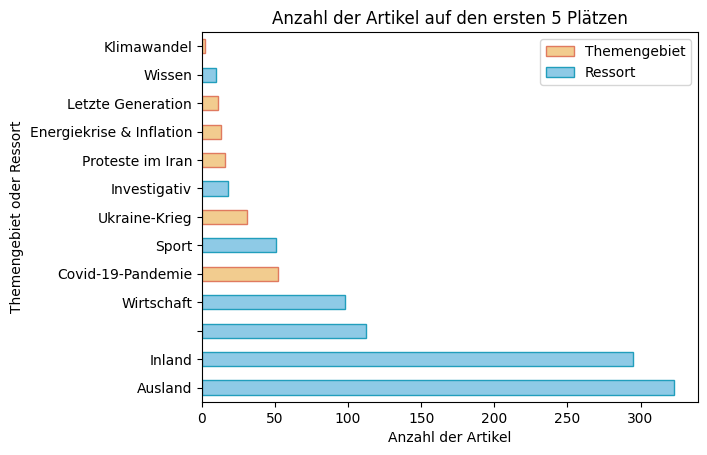

In [16]:
ax = df.plot(kind="barh", x='group', y='amount', xlabel="Anzahl der Artikel", ylabel="Themengebiet oder Ressort", color=df.color, legend=False, edgecolor=df.edgecolor)

legend_elements = [Patch(facecolor='#f2cc8f', edgecolor='#e07a5f', label='Themengebiet'), Patch(facecolor='#8ecae6', edgecolor='#219ebc', label='Ressort')]
ax.legend(handles=legend_elements);

ax.set_title('Anzahl der Artikel auf den ersten 5 Plätzen')
ax.get_figure().savefig('figures/bar-ranking-ressort-topic.png', bbox_inches="tight", dpi=float(dpi))